In [66]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch_geometric
import matplotlib.colors as mcolors
import heapq
from torch_geometric.datasets import Planetoid

Suppose each of the 7 classes of the CORA dataset correspond to a cluster of papers derived from KMeans.

We ultimately need citation network dataset with paper metadata (e.g., http://aminer.org/citation). We then perform K-means clustering on this dataset based on keywords and/or abstract to produce research topic clusters.

In [67]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

data = dataset[0]
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [68]:
# Convert the edge index to a NetworkX graph
G = nx.DiGraph()

# Add edges to the graph
edge_index = data.edge_index
classes = data.y

for i in range(classes.shape[0]):
    G.add_node(i, label=classes[i].item())
    
for i in range(edge_index.shape[1]):
    source = edge_index[0, i].item()
    target = edge_index[1, i].item()
    G.add_edge(source, target)

In [69]:
def get_nodes_of_class(graph, class_label):
    return [node for node, attr in graph.nodes(data=True) if attr['label'] == class_label]

In [70]:
class_subgraphs = {}
for class_label in set(classes.numpy()):
    nodes_of_class = get_nodes_of_class(G, class_label)
    subgraph = G.subgraph(nodes_of_class).copy()
    class_subgraphs[class_label] = subgraph

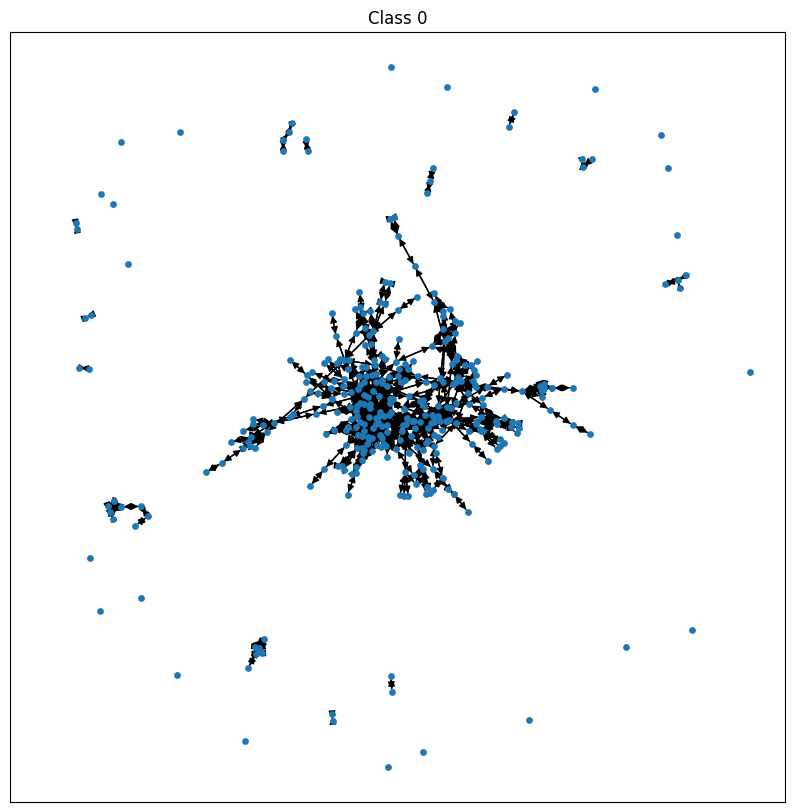

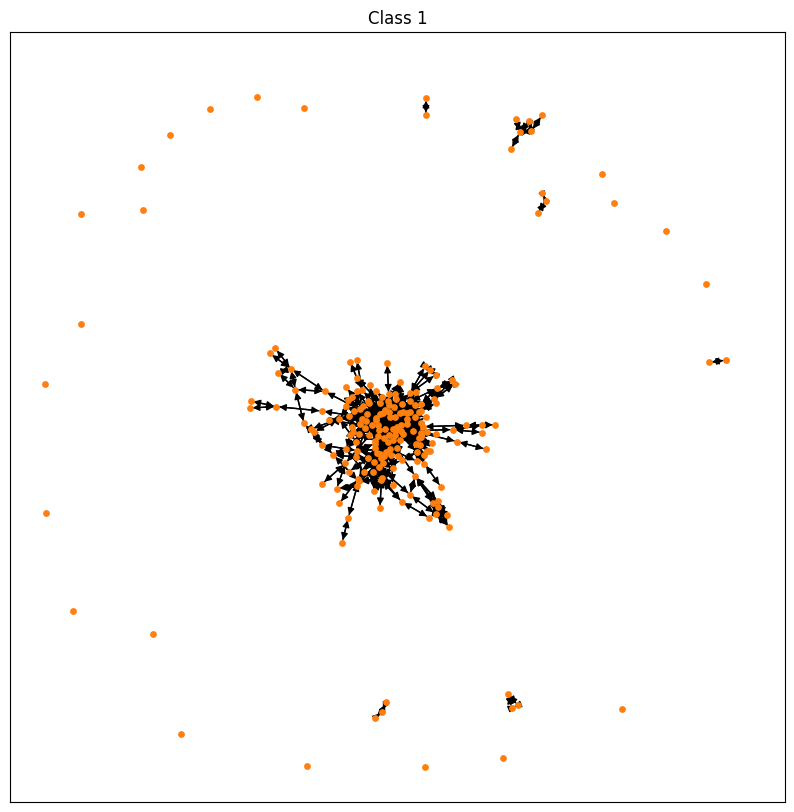

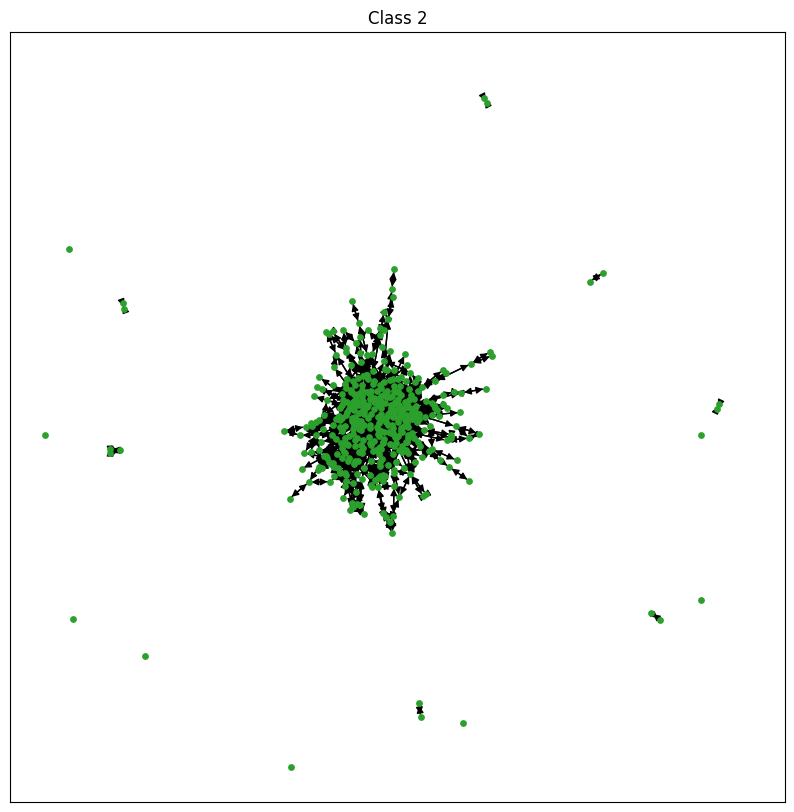

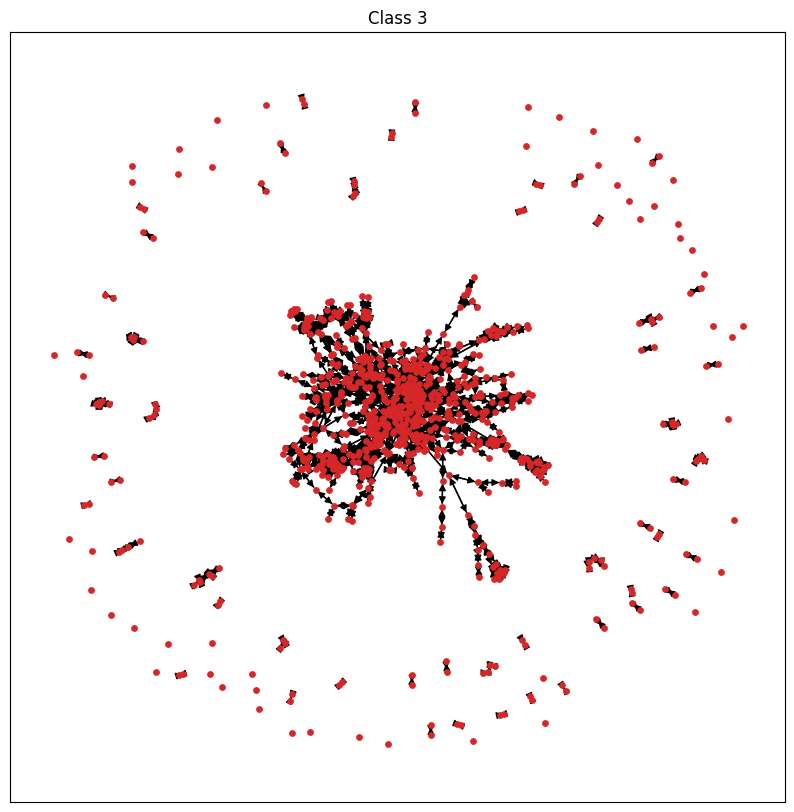

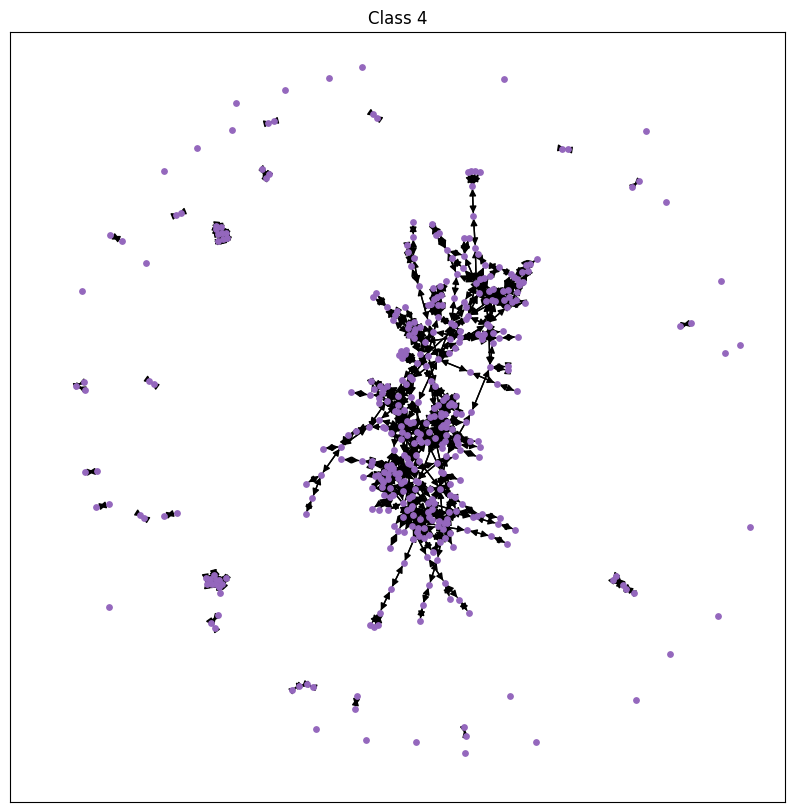

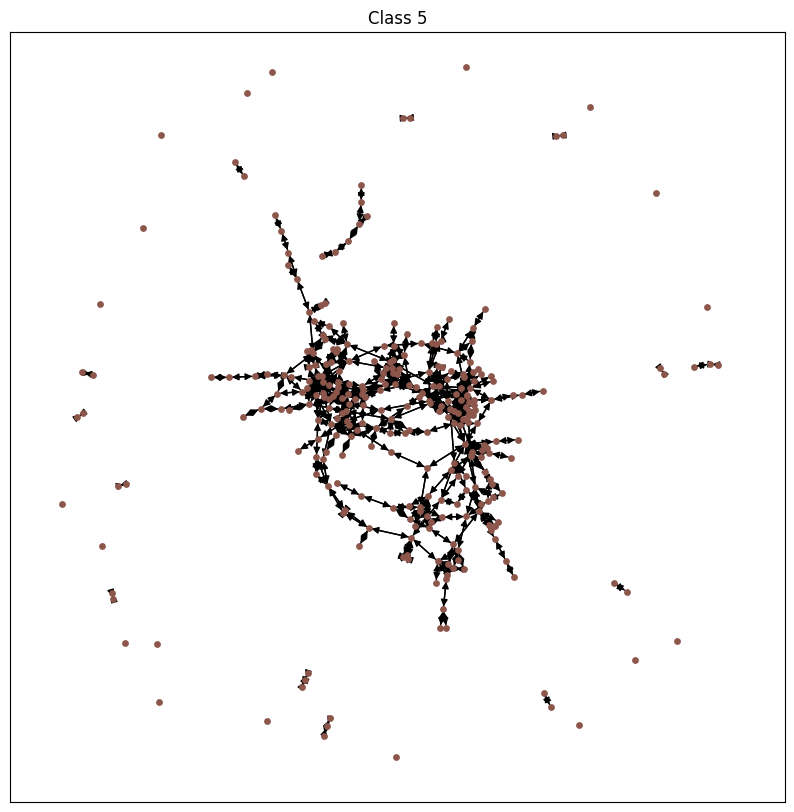

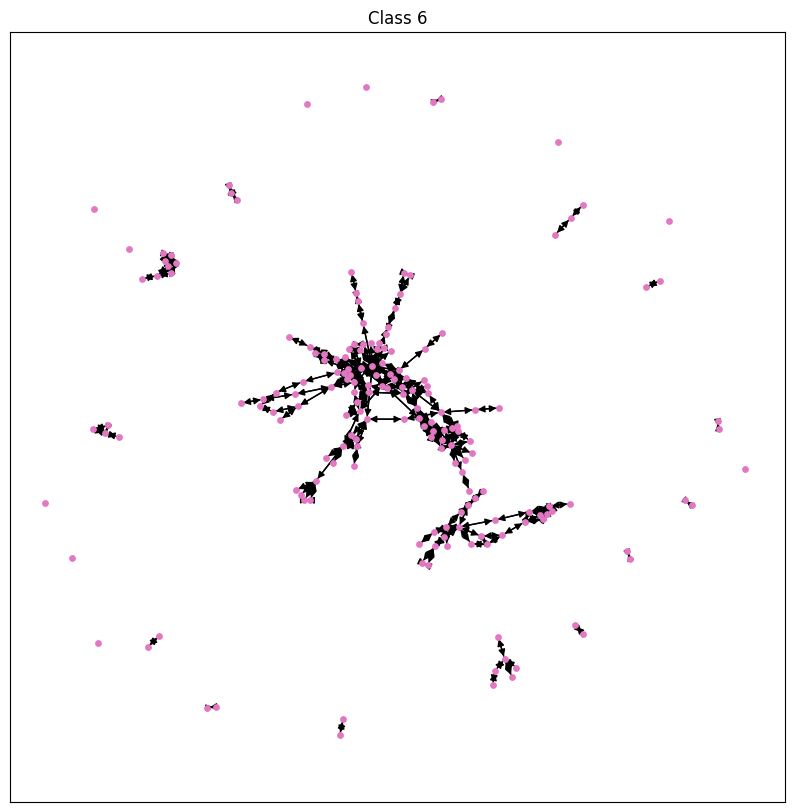

In [71]:
num_classes = len(set(classes.numpy()))
colors = list(mcolors.TABLEAU_COLORS.values())[:num_classes]

for i, (class_label, subgraph) in enumerate(class_subgraphs.items()):
    plt.figure(figsize=(10, 10))
    color = colors[class_label]
    nx.draw_networkx(subgraph, node_color=color, node_size=15, with_labels=False, edge_color='black')
    plt.title(f"Class {class_label}")
    plt.show()

In [73]:
for class_label, subgraph in class_subgraphs.items():
    k = 5
    print(f"Top {k} Papers with Highest PageRank - Class {class_label}")
    class_pagerank = nx.pagerank(subgraph)
    
    # Given number of classes k = 10, heapq.nlargest has complexity of O(n * log(k))
        # O(log(k)) to heapify first k elements
        # O((n - k) * log(k)) = O(n * log(k)) to push/pop remaining elements to maintain max heap of size k
        # Total: O(log(k) + n * log(k)) = O(n * log(k))
    # Better than sorting all entries of class_pagerank and choosing the top 10: O(n * log(n))
    # Edit: More precise breakdown https://github.com/python/cpython/blob/3.8/Lib/heapq.py#L412
    # Shoutout EECS 281

    top = heapq.nlargest(k, class_pagerank.items(), key=lambda x: x[1])
    for node, pr in top:
        print(f"Node: {node} | PR-score: {pr}")
    print()
    

Top 5 Papers with Highest PageRank - Class 0
Node: 1042 | PR-score: 0.015409183002129572
Node: 2182 | PR-score: 0.013908231344877621
Node: 95 | PR-score: 0.012670716476652525
Node: 1416 | PR-score: 0.01212652921730898
Node: 1013 | PR-score: 0.010513421188638688

Top 5 Papers with Highest PageRank - Class 1
Node: 306 | PR-score: 0.06209765782074479
Node: 1623 | PR-score: 0.037767498565676176
Node: 109 | PR-score: 0.025796454601233303
Node: 2045 | PR-score: 0.022243935366748117
Node: 1624 | PR-score: 0.013901095142374281

Top 5 Papers with Highest PageRank - Class 2
Node: 1358 | PR-score: 0.07759084119737918
Node: 1169 | PR-score: 0.01081140329941033
Node: 1103 | PR-score: 0.008924982375232888
Node: 1765 | PR-score: 0.008574700021613776
Node: 1483 | PR-score: 0.007896923337089377

Top 5 Papers with Highest PageRank - Class 3
Node: 1701 | PR-score: 0.022819472946768875
Node: 1986 | PR-score: 0.01627181460058635
Node: 1810 | PR-score: 0.013444178720482858
Node: 598 | PR-score: 0.0088335463